# Sensitivity Tests Output

Working with the output from HiPerGator/main.py

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from tqdm import tqdm


import photoeccentric as ph


plt.rcParams['figure.dpi'] = 150

In [46]:
fitew = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/uniform/fitew.txt', index_col=False)

truee = np.array(fitew['truee'])
truew = np.array(fitew['truew'])

fite = np.array(fitew['fite'])
fitw = np.array(fitew['fitw'])

e_errors = np.abs(truee-fite)

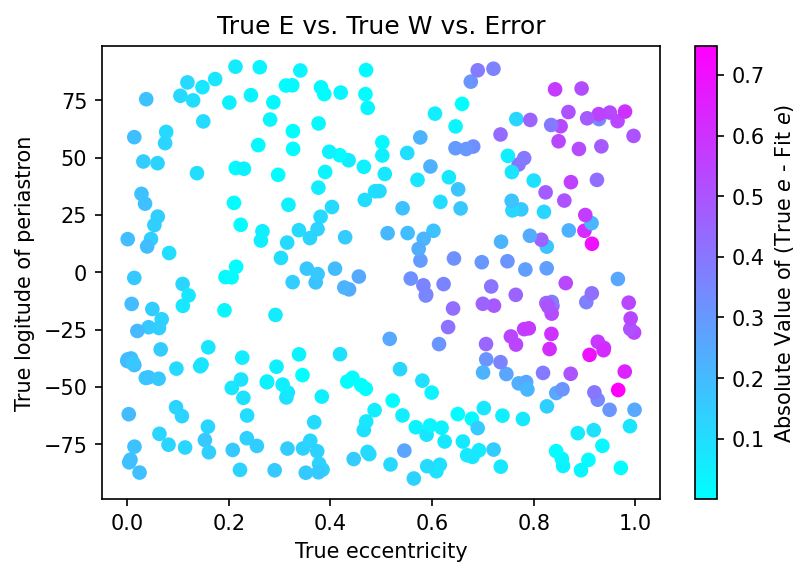

In [47]:
plt.scatter(truee, truew, c=e_errors, cmap='cool')
plt.xlabel('True eccentricity')
plt.ylabel('True logitude of periastron')
plt.title('True E vs. True W vs. Error')

plt.clim(min(abs(e_errors)), max(abs(e_errors)))
plt.colorbar(label='Absolute Value of (True $e$ - Fit $e$)')
plt.savefig('nodiv_scatter_eerror.png')

# Heatmap

100%|██████████| 319/319 [00:00<00:00, 16064.15it/s]
<ipython-input-48-2a0cb51168a1>:142: RuntimeWarning: invalid value encountered in double_scalars
  counts.T[i][j] = counts.T[i][j]/counts_tot.T[i][j]


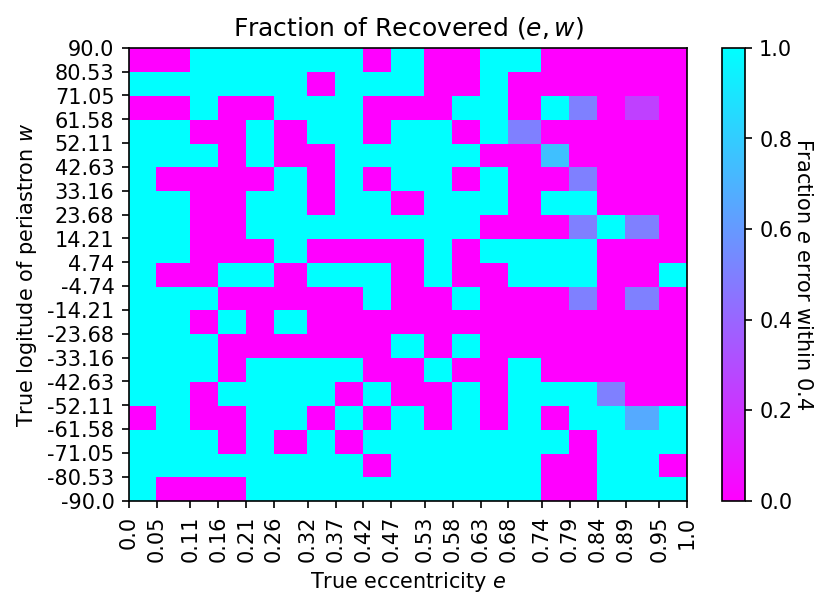

In [48]:
def heatmap_bins(e_min, e_max, nebins, w_min, w_max, nwbins, loge=False):
    """
    Gets bin edges for detection efficiency heatmap.
    
    Parameters
    ----------
    e_min: float
        Minimum e in sample
    period_max: float
        Maximum period in sample
    nperbins: int
        Number of period bins in heatmap
    rprs_min: float
        Minimum Rp/Rs in sample (or radius)
    rprs_max: float
        Maximum Rp/Rs in sample (or radius)
    nradbins: int
        Number of radius bins in heatmap
    logper: boolean, default True
        Log x (period)-axis?

    Returns
    -------
    per_segments: np.array
        Array of x-axis (period) bin edges
    rprs_segments: np.array
        Array of y-axis (radius) bin edges
    
    """

    if loge==True:

        natural_val = np.linspace(e_min, np.log10(e_max), num=nebins, endpoint=True).round(decimals=2)
        e_segments = np.array([10**x for x in natural_val]).round(decimals=2)
        
    if loge==False:
        
        e_segments = np.linspace(e_min, e_max, num=nebins, endpoint=True).round(decimals=2)

    
    w_segments = np.linspace(w_min, w_max, num=nwbins).round(decimals=2)
    
    return e_segments, w_segments


# Getting bin edges
e_segments, w_segments = heatmap_bins(0.0, 1.0, 20, -90., 90., 20, loge=False)

def is_recovered(error, e, fe, w, fw, e_segments, w_segments):#true (injected) period, L-M fitting period, true rp/rs, L-M fitting rp/rs
    
    """
    Determines whether a planet is recovered.
    
    ** Note **
    The first if-statement can be changed to reflect the conditions for planet recovery.
    
    ** Note **
    r_list, recovered_period, and recovered_rprs must be defined outside of this function (see cell below)
    
    
    Parameters
    ----------
    period: float
        True (known) period of simulated planet
    fitper: float
        Fit (recovered) period of simulated planet
    rprs: float
        True (known) Rp/Rs of simulated planet
    fitrprs: float
        Fit (recovered) Rp/Rs of simulated planet
    per_segments: np.array
        Period bin edges
    rprs_segments: np.array
        Radius bin edges
        
    Returns
    -------
    None
    
    
    """
    if error < 0.4:
    #You can define your own definition of "recovered" here.
    
        recovered = True
        
        recovered_es.append(e)
        recovered_ws.append(w)
        
        for e_i in range(len(e_segments)-1):
            for w_i in range(len(w_segments)-1):
                if e_segments[e_i] < e < e_segments[e_i+1]:
                    if w_segments[w_i] < w < w_segments[w_i+1]:
                        r_list[w_i][e_i] += 1
                        
    else:
        
        recovered = False


# Define lists to save for heatmap
r_list = np.zeros((len(e_segments), len(w_segments)))
recovered_es = []
recovered_ws = []


for i in tqdm(range(len(truee))):
    is_recovered(e_errors[i], truee[i], fite[i], truew[i], fitw[i], e_segments, w_segments)

def plot(recovered_es, recovered_ws, true_es, true_ws, filename='e_w_heatmap.png', xlog=False):
    
    """
    Plots + saves detection efficiency heatmap
    
    Parameters
    ----------
    recovered_period: np.array
        Array of "fit" es
    recovered_rprs: np.array
        Array of "fit" ws
    true_periods: np.array
        Array of true (simulated) periods
    true_rprs: np.array
        Array of true (simulated) radii
    filename: str, default 'heatmap.png'
        Directory + filename to save heatmap
    xlog: boolean, default True
        Log x-axis? Must match logper argument in heatmap_bins()
        
    Returns
    -------
    fig: matplotlib.figure.Figure object
        Heatmap
    
    """
    
    counts, _, _ = np.histogram2d(recovered_es, recovered_ws, bins=(e_segments, w_segments))
    counts_tot, _, _ = np.histogram2d(true_es, true_ws, bins=(e_segments, w_segments))

    for i in range(len(counts.T)):
        for j in range(len(counts.T[i])):
            counts.T[i][j] = counts.T[i][j]/counts_tot.T[i][j]
            if np.isnan(counts.T[i][j]):
                counts.T[i][j] = 0

    matplotlib.rcParams['xtick.minor.size'] = 0
    matplotlib.rcParams['xtick.minor.width'] = 0

    fig, ax = plt.subplots()
    heatmap = ax.pcolormesh(e_segments, w_segments, counts.T, cmap='cool_r')
    
    if xlog==True:
        ax.set_xscale('log')

    ax.xaxis.set_ticks(e_segments)
    ax.xaxis.set_ticklabels(e_segments, fontsize=10, rotation='vertical')

    ax.yaxis.set_ticks(w_segments)
    ax.yaxis.set_ticklabels(w_segments)

    ax.set_title('Fraction of Recovered $(e,w)$')
    ax.set_xlabel('True eccentricity $e$')
    ax.set_ylabel('True logitude of periastron $w$')


    cbar = plt.colorbar(heatmap)
    heatmap.set_clim(0.0, 1.0)
    cbar.set_label('Fraction $e$ error within 0.4', rotation=270, labelpad=10)


    plt.savefig(filename)
    plt.show()
    
    return fig


heatmap = plot(recovered_es, recovered_ws, truee, truew, xlog=False)
